In [1]:
import marimo as mo

# Module 11 - Applying Reinforcement Learning to Language

The goal of this activity is to build intuition on how Reinforcement Learning can modify the behavior of a language model. This is a very simplified toy example, but will help us understand how the RL concepts like **states** and **actions** translate to the world of text and what are some of the tradeoffs that need to be made when working with reinforcement learning.

Let's first construct a simplified language model. Our model will have a set vocabulary size **vocab_size**, so for simplicity we'll use a subset of **vocab_size** words from the vocabulary of english words in the **nltk** library .

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import nltk
import numpy as np
import torch.nn.functional as F

# Download word list (only needs to be done once)
nltk.download('words')

from nltk.corpus import words

def build_a_vocab(vocab_size=200, min_len=3, max_len=8, seed=42):
    all_words = words.words()
    filtered = [
        w.lower() for w in all_words
        if w.isalpha() and min_len <= len(w) <= max_len
    ]
    unique = sorted(set(filtered))
    random.seed(seed)
    selected = random.sample(unique, vocab_size)
    return selected

vocab = build_a_vocab(vocab_size=1000)
word_to_idx = {w: i for i, w in enumerate(vocab)}
idx_to_word = {i: w for w, i in word_to_idx.items()}

print("Sample vocab:", vocab[:10])
print("Total words:", len(vocab))

vocab_size = len(vocab)

Sample vocab: ['vowmaker', 'chic', 'andiroba', 'imonium', 'group', 'funnyman', 'crusie', 'castice', 'streaky', 'bryozoan']
Total words: 1000


[nltk_data] Downloading package words to /Users/gurgentus/nltk_data...
[nltk_data]   Package words is already up-to-date!


To simulate a language model generating text, we'll use a simple model that generates the next word starting with the last letter of the context. We will use a small one layer neural network that outputs probabilities for different words in the vocabulary and then choose the word with the highest probability that satisfies the word chain condition above.

To obtain a numeric tensor, we will use one-hot encoding to represent the context, where each word in the vocabulary is represented by a unique index.

In [3]:
# simple one layer neural network that will act as our language model
class SimpleNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.activation = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = self.fc1(state)
        x = self.activation(x)
        return self.fc2(x)

# our neural network takes a tensor as input, so we need to transform the
# context into a tensor of one-hot encoded vectors.
def encode_sequence_state(context, context_size=3):
    # Encodes the context as a one-hot vector of size (context_size * vocab_size)
    vec = torch.zeros(context_size * vocab_size, dtype=torch.float32)
    # Ensure the context is at least as long as context_size
    last_k = context[-context_size:] if len(context) >= context_size else context
    # Offset determines which word in the context to start filling in
    offset = context_size - len(last_k)

    for i, idx in enumerate(last_k):
        vec[(offset + i) * vocab_size + idx] = 1.0
    return vec

# checks if the word chain condition is satisfied, i.e. the first
# letter of the current word matches the last letter of the previous word.
def is_valid_transition(prev, curr):
    return curr[0] == prev[-1]

# to generate text from the base model, we need to encode the context,
# get the probabilities for the next word logits, and sample from the distribution
def generate_text_from_base_model(context, base_model):
    encoded_context = encode_sequence_state(context).unsqueeze(0)
    next_word_logits = base_model(encoded_context)

    admissible_idxs = [i for i, w in enumerate(vocab) if is_valid_transition(idx_to_word[context[-1]], w)]
    next_word_probabilities = F.softmax(next_word_logits[0][admissible_idxs], dim=-1)
    next_word_dist = torch.distributions.Categorical(next_word_probabilities)
    next_word_sample = next_word_dist.sample()
    return admissible_idxs[next_word_sample.item()], next_word_dist.log_prob(next_word_sample)


Feel free to expertiment with trying different context below:

In [4]:
base_model = SimpleNet(input_dim=vocab_size * 3, hidden_dim=64, action_dim=vocab_size)

context = [10, 23, 40]
print("Context: ", [idx_to_word[ind] for ind in context])
completion = []
for _i in range(5):
    next_word_index, _  = generate_text_from_base_model(context, base_model)
    context.append(next_word_index)
    completion.append(idx_to_word[next_word_index])
print("Completion: ", ', '.join(completion))

Context:  ['tripsome', 'strait', 'canalman']
Completion:  nymphine, enkernel, laic, chalque, ethiopia


This is the base model behavior. What happens if we want to modify it? Say we want to generate new text in such a way that the last word in the chain ends in the letter **m**.

We could train a new model or fine-tune the existing model, but that would require many examples of this behavior. Can we make our text generation behave in the way we want by simply having it experiment on its own? All we would need would be some rules to tell it if it is doing a good job. This is a perfect setup for using Reinforcement Learning.

Let's put this problem in an RL setting of states, actions, and rewards. The **state** will be the current context of length **context_size**.

The **action** is simply choosing one of the words from the vocabulary.

The **reward** is where things get interesting. The idea is to shape it in a way to get the behavior we want.

In [5]:
def shaped_reward(sequence):
    reward = 0.0
    for i in range(1, len(sequence)):
        if is_valid_transition(sequence[i - 1], sequence[i]):
            reward += 1.0
        else:
            reward -= 3.0

    if sequence[-1][-1] == 'm':
        reward += 50
    else:
        reward -= 10

    return reward

Finally, the **environment** will be represented by a class that holds the current state of the text generation process and provides methods to reset the state and step through the environment by taking an action (choosing a word). The environment also computes the reward based on the generated sequence.

In [6]:
class Environment:
    def __init__(self, max_seq_length):   
        self.state = []
        self.context_size = 3
        self.max_seq_length = max_seq_length

    def reset(self, start_word=None):
        start_idx = word_to_idx[start_word] if start_word else word_to_idx[random.choice(vocab)]
        self.state = [start_idx]
        context = self.state[-3:]
        return context

    def step(self, action):
        self.state = list(self.state) + [action]
        new_context = self.state[-3:]
        reward = 0;
        done = False
        if ((idx_to_word[self.state[-1]][-1] == 'm') or len(self.state) == self.max_seq_length):
            done = True
            sequence = [idx_to_word[i] for i in self.state]
            reward = shaped_reward(sequence)

        return new_context, reward, done

In [7]:
env = Environment(max_seq_length=5)
_context = env.reset("strait")
print("Current context: ", [idx_to_word[word] for word in _context])

# one step in the environment
_new_context, _reward, _done = env.step(word_to_idx["group"])
print("New context: ", [idx_to_word[word] for word in _new_context])

Current context:  ['strait']
New context:  ['strait', 'group']


How should the agent choose the next action (next word)? Here is an example of a policy implementation based on the algorithm described and implemented in https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html.

The `get_action` function simply uses the neural network model to output the next action, as we did before. The details of the training algorithm below and the specific loss function used for RL is beyond the scope of the course, but note that it is a generic algorithm for RL, not specific for language modeling.

Pay particular attention to the last several lines where the usual backpropogation to perform gradient descent with respect to this loss function is used to update the weights of the base neural network. In case you are interested in diving more into the theory, the code in this cell is copied with minimal modifications from above to make the comparison with the theory easier.

In [8]:
class Policy:
    def __init__(self, model, optimizer, batch_size):
        self.model = model
        self.optimizer = optimizer
        self.batch_size = batch_size

    # make action selection function (outputs int actions, sampled from policy)
    def get_action(self, obs):  
        return generate_text_from_base_model(obs, self.model)

    # make loss function whose gradient, for the right data, is policy gradient
    def compute_loss(self, logp, weights):
        return -(logp * weights).mean()

    # for training policy
    def train_one_epoch(self):
        # make some empty lists for logging.
        batch_obs = []          # for observations
        batch_acts = []         # for actions
        batch_weights = []      # for R(tau) weighting in policy gradient
        batch_rets = []         # for measuring episode returns
        batch_lens = []         # for measuring episode lengths
        batch_logp = []

        # reset episode-specific variables
        obs = env.reset()       # first obs comes from starting distribution
        done = False            # signal from environment that episode is over
        ep_rews = []            # list for rewards accrued throughout ep

        # render first episode of each epoch
        finished_rendering_this_epoch = False

        # collect experience by acting in the environment with current policy
        while True:
            # save obs
            batch_obs.append(obs)

            # act in the environment
            act, logp = self.get_action(obs)
            obs, rew, done = env.step(act)

            # save action, reward
            batch_acts.append(act)
            ep_rews.append(rew)
            batch_logp.append(logp)

            if done:
                # if episode is over, record info about episode
                ep_ret, ep_len = sum(ep_rews), len(ep_rews)
                batch_rets.append(ep_ret)
                batch_lens.append(ep_len)

                # the weight for each logprob(a|s) is R(tau)
                batch_weights += [ep_ret] * ep_len

                # reset episode-specific variables
                obs, done, ep_rews = env.reset(), False, []

                # won't render again this epoch
                finished_rendering_this_epoch = True

                # end experience loop if we have enough of it
                if len(batch_obs) > self.batch_size:
                    break

        # take a single policy gradient update step
        self.optimizer.zero_grad()
        batch_loss = self.compute_loss(logp,
                            weights=torch.as_tensor(batch_weights, dtype=torch.float32))
        batch_loss.backward()
        self.optimizer.step()
        return batch_loss, batch_rets, batch_lens


Next, let's train the model. Each epoch consists of `batch_size` of observations, where each episode is a sequence of actions taken by the agent in the environment until the end condition. The agent interacts with the environment, collects rewards, and updates its policy based on the rewards received.

In [9]:
epochs = 1000
batch_size = 30

lr=1e-2
input_dim = 3 * vocab_size
policy_nn = SimpleNet(input_dim, hidden_dim=256, action_dim=vocab_size)

optimizer = torch.optim.Adam(policy_nn.parameters(), lr=lr)
policy = Policy(policy_nn, optimizer, batch_size)

# training loop
reward_history = []
for epoch in range(epochs):
    batch_loss, batch_rets, batch_lens = policy.train_one_epoch()
    reward_history.append(np.mean(batch_rets))
    if epoch % 100 == 0:
        print('epoch: %3d \t loss: %.3f \t return: %.3f \t ep_len: %.3f'%
            (epoch, batch_loss, np.mean(batch_rets), np.mean(batch_lens)))

epoch:   0 	 loss: 12.481 	 return: 7.111 	 ep_len: 3.778
epoch: 100 	 loss: -27.284 	 return: -6.000 	 ep_len: 4.000
epoch: 200 	 loss: 1.091 	 return: 37.583 	 ep_len: 2.583
epoch: 300 	 loss: 0.000 	 return: 52.214 	 ep_len: 2.214
epoch: 400 	 loss: 0.026 	 return: 52.583 	 ep_len: 2.583
epoch: 500 	 loss: 0.000 	 return: 47.929 	 ep_len: 2.214
epoch: 600 	 loss: 2.779 	 return: 52.214 	 ep_len: 2.214
epoch: 700 	 loss: 0.000 	 return: 52.286 	 ep_len: 2.286
epoch: 800 	 loss: 0.000 	 return: 47.583 	 ep_len: 2.583
epoch: 900 	 loss: 0.000 	 return: 47.929 	 ep_len: 2.214


epoch: 100 	 loss: -5.048 	 return: 0.444 	 ep_len: 3.778


epoch: 200 	 loss: -9.633 	 return: 0.444 	 ep_len: 3.778


epoch: 300 	 loss: 6.263 	 return: 7.000 	 ep_len: 3.667


epoch: 400 	 loss: -21.877 	 return: -6.000 	 ep_len: 4.000


epoch: 500 	 loss: -22.409 	 return: -6.000 	 ep_len: 4.000


epoch: 600 	 loss: 0.001 	 return: 22.750 	 ep_len: 2.750


epoch: 700 	 loss: 0.000 	 return: 29.300 	 ep_len: 3.300


epoch: 800 	 loss: 0.000 	 return: 35.200 	 ep_len: 3.200


epoch: 900 	 loss: 0.000 	 return: 34.154 	 ep_len: 2.615


In [10]:
import matplotlib.pyplot as plt

def plot_rewards(rewards):
    plt.figure(figsize=(10, 4))
    plt.plot(rewards, alpha=0.4, label="Raw reward")
    if len(rewards) >= 100:
        smoothed = torch.tensor(rewards).unfold(0, 100, 1).mean(1)
        plt.plot(range(99, len(rewards)), smoothed, label="Smoothed (100 ep)")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Training Progress")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

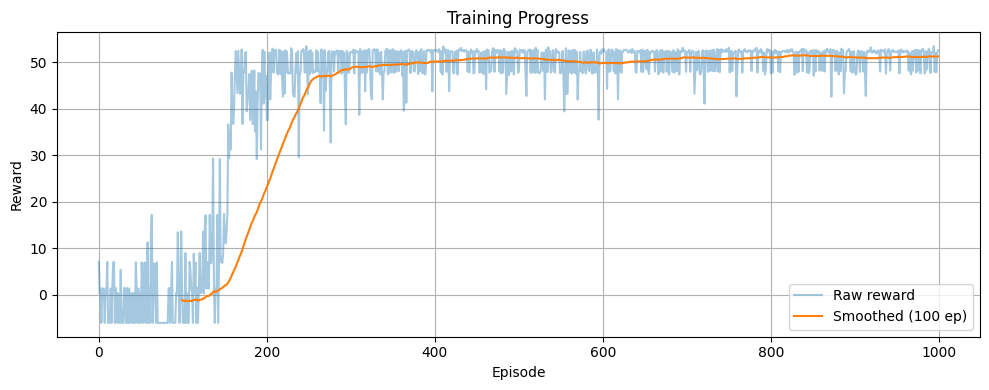

In [11]:
plot_rewards(reward_history)

The model is now trained and we can generate new text! Note, how our reward shape affected the generation. Feel free to experiment with increasing vocabulary size, maximum sequence length and the reward shape (e.g. can we reward the model for making longer or shorter chains or having some other interesting structure.)

In [12]:
def generate_chain(start_word, policy):
    # make some empty lists for logging.
        batch_observations = []          # for observations
        # reset episode-specific variables
        context = env.reset(start_word)
        done = False            # signal from environment that episode is over
        # collect experience by acting in the environment with current policy
        while True:
            # act in the environment
            action, _ = policy.get_action(context)
            context, _, done = env.step(action)
            batch_observations.append(idx_to_word[context[-1]])
            if done:
                return batch_observations

In [13]:
start_word = random.choice(vocab)
print("Start word: ", start_word)

chain = generate_chain(start_word, policy)
print(" → ".join(chain))

Start word:  inhaler
reliance → endbrain → negrodom
